# Analysis of object exploration

''' Created on Wed 12 Aug 2020'''


We will use the same tools that we use for exploration analysis but now dividing the data into parts corresponding to the different objects/positions that are being explored by the mouse. 

The idea is to separate the data for those different object exploration, create one matrix with the first N seconds of exploration, creaty the mean activity plot, and with that data produce the signal correlation matrix and the noise correlation matrix, and finally perform tSNE in that data to look for clusters and manifold patterns. 

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
from sklearn.manifold import TSNE
cmap = cm.jet

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165          ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                ## value of resampling

session_now = 1
period = 6
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
            if mouse == 32364:
                fixed = 'UL and UR'
            if mouse == 56165:
                fixed = 'UR and LR (verify)'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/object_exploration/'

In [4]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'

In [5]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf

In [6]:
events_list = []
events_counter_list = []
events_time_starts = []
start_counter = 100
counter = 0
for i in range(resample_beh1.shape[0]):
    if resample_beh1[i] != start_counter:
        events_list.append(start_counter)
        events_counter_list.append(counter)
        events_time_starts.append(i)
        start_counter = resample_beh1[i]
        counter = 1
    else:
        counter = counter + 1

In [7]:
events = np.array(events_list)
events_counter = np.array(events_counter_list)
events_time = np.array(events_time_starts)

conditions = [ 'LL', 'LR', 'UR', 'UL']

object_list = []
for target in [2,3,4,5]:
    object_data = []
    position_events = np.where(events == target)[0]
    events_duration = events_counter[position_events]   # convert to seconds
    time = events_time[position_events]
    i = 0
    for event in events_duration:
        if event > period:
            object_data.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
        i = i + 1
    object_list.append(object_data)


0
1
2
3


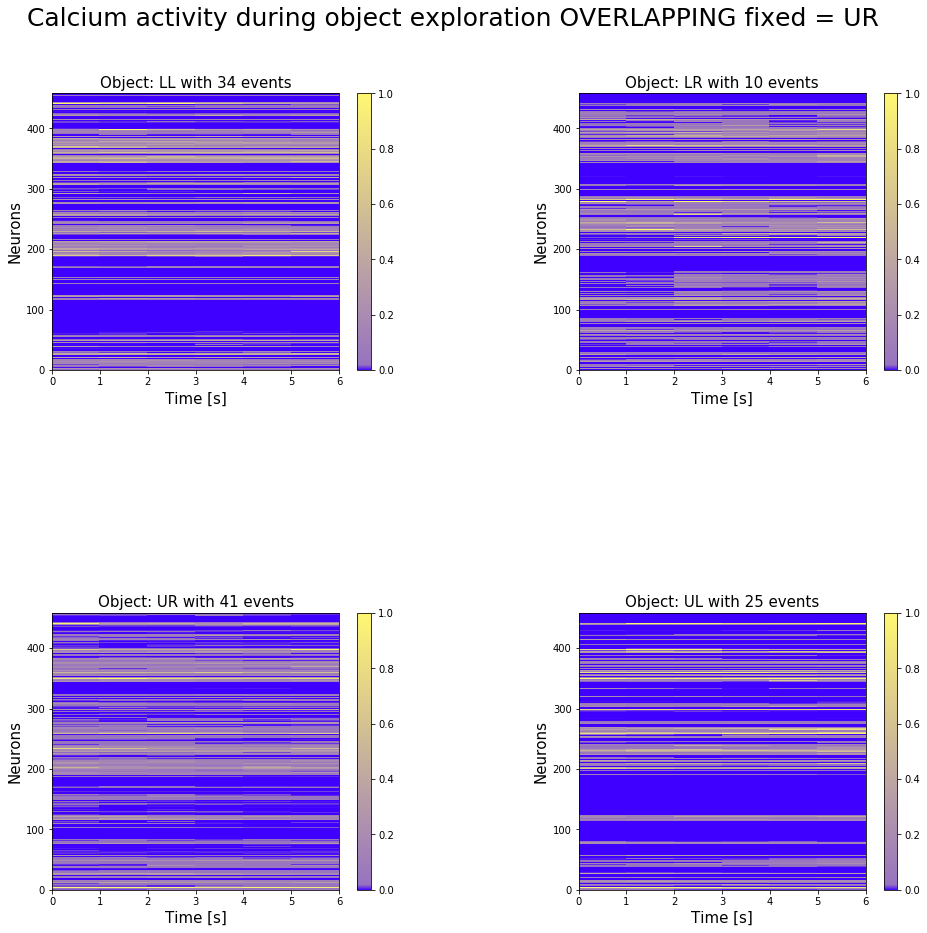

In [8]:
mean_over_trials_list = []
for i in range(len(object_list)):
    mean_over_trials= np.mean(object_list[i], axis= 0)
    mean_over_trials_list.append(mean_over_trials)

import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


vmin= 0
vmax=1
fig = plt.figure()
gs = plt.GridSpec(2, 2)

for i in range(2):
    for j in range(2):
        counter = i*2+j
        if object_list[counter]:
            ax = fig.add_subplot(gs[i, j])
            print(counter)
            ax.set_title('Object: '+ conditions[counter] + ' with ' + f'{len(object_list[counter])}' + ' events' , fontsize = 15)
            ax.set_ylabel('Neurons', fontsize = 15)
            ax.set_xlabel('Time [s]', fontsize = 15)
            mesh = ax.pcolormesh(mean_over_trials_list[counter], cmap = cm)
            mesh.set_clim(vmin,vmax)
            fig.colorbar(mesh,ax=ax)
        
fig.tight_layout()
fig.set_size_inches(15,15)
fig.suptitle('Calcium activity during object exploration ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'calcium_activity_object_exploration_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

## Sorted by maximum firing rate

In [9]:
### sorted by mean firing rate
mean_over_trials_list = []
corr_matrix_signal_list = []
corr_matrix_noise_list = []
matrix_list = []
for i in range(len(object_list)):
    if object_list[i]: 
        mean_over_trials =  np.mean(object_list[i], axis= 0)
        mean_firing_rate = np.mean(mean_over_trials, axis = 1)
        positions = np.flip(np.argsort(mean_firing_rate))
        new_mean_over_trials = mean_over_trials[positions,:]
        non_zero_positions = np.where(np.mean(new_mean_over_trials,axis=1))
        non_zero_mean_over_trials = new_mean_over_trials[non_zero_positions,:]
        non_zero_mean_over_trials = non_zero_mean_over_trials [0,:,:]
        mean_over_trials_list.append(non_zero_mean_over_trials)

        positions1 = positions[np.where(mean_firing_rate[positions])]
        corr_matrix2 = stats.corr_matrix(neural_activity = non_zero_mean_over_trials)
        corr_matrix_signal_list.append(corr_matrix2)

        matrix = np.zeros((positions1.shape[0],period*len(object_list[i])))
        for j in range(len(object_list[i])):
            matrix[:,j*period:(j+1)*period] = object_list[i][j][positions1,:] - mean_over_trials[positions1,:]
        matrix_list.append(matrix)
        corr_matrix = stats.corr_matrix(neural_activity = matrix)
        corr_matrix_noise_list.append(corr_matrix)

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


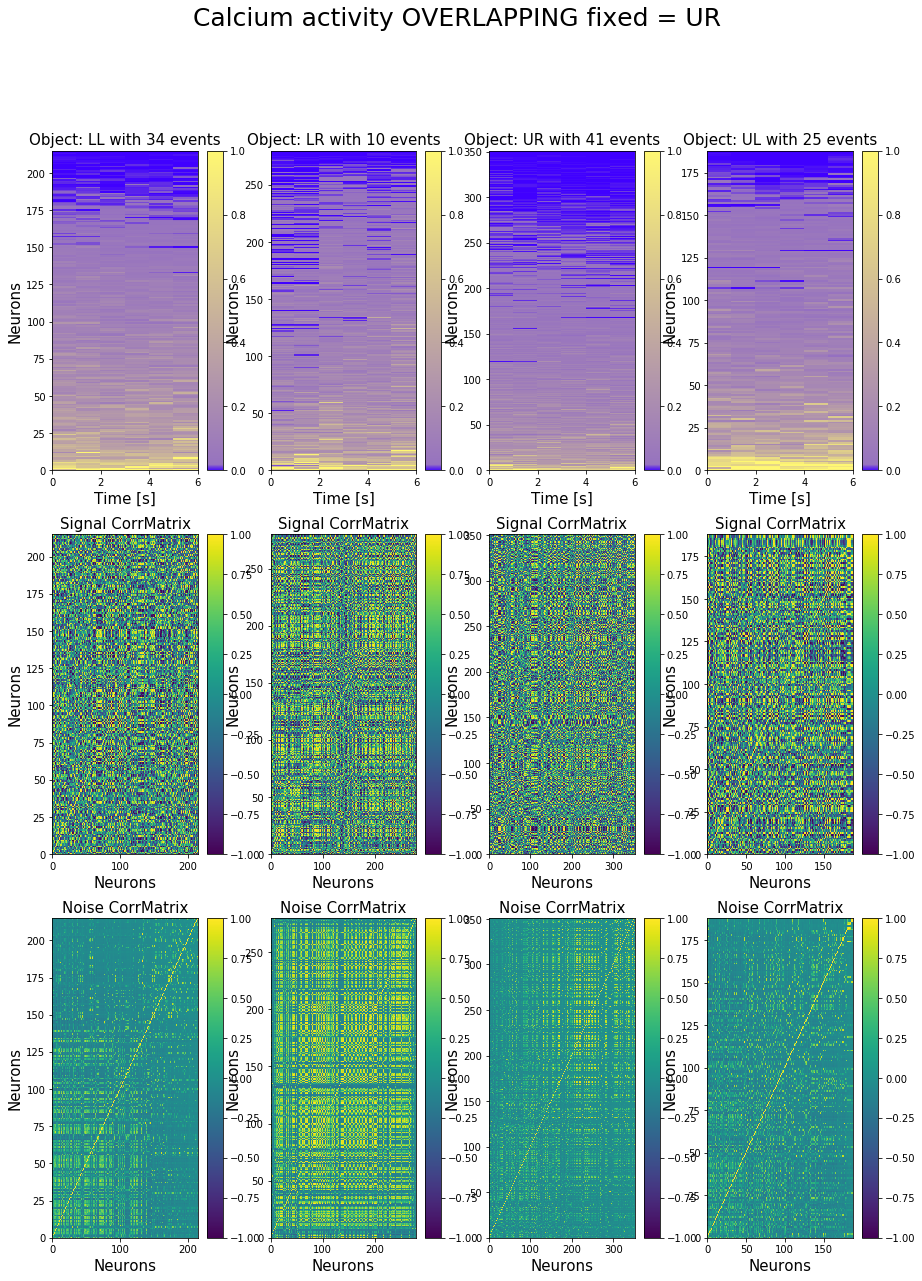

In [10]:
vmin= 0
vmax=1
fig = plt.figure()
gs = plt.GridSpec(3, 4)

i=0
for j in range(4):
    if object_list[j]: 
        ax = fig.add_subplot(gs[i, j])
        ax.set_title('Object: '+ conditions[j] + ' with ' + f'{len(object_list[j])}' + ' events' , fontsize = 15)
        ax.set_ylabel('Neurons', fontsize = 15)
        ax.set_xlabel('Time [s]', fontsize = 15)
        mesh = ax.pcolormesh(mean_over_trials_list[j], cmap = cm)
        mesh.set_clim(vmin,vmax)
        fig.colorbar(mesh,ax=ax)


vmin_corr = -1
vmax_corr = 1
i=1
for j in range(4):
    if object_list[j]: 
        ax3 = fig.add_subplot(gs[i, j])
        ax3.set_ylabel('Neurons', fontsize = 15)
        ax3.set_xlabel('Neurons', fontsize = 15)
        ax3.set_title('Signal CorrMatrix', fontsize = 15)
        mesh3 = ax3.pcolormesh(corr_matrix_signal_list[j], cmap = 'viridis')
        mesh3.set_clim(vmin_corr,vmax_corr)
        fig.colorbar(mesh3,ax=ax3)

i=2
for j in range(4):
    if object_list[j]: 
        ax3 = fig.add_subplot(gs[i, j])
        ax3.set_ylabel('Neurons', fontsize = 15)
        ax3.set_xlabel('Neurons', fontsize = 15)
        ax3.set_title('Noise CorrMatrix', fontsize = 15)
        mesh3 = ax3.pcolormesh(corr_matrix_noise_list[j], cmap = 'viridis')
        mesh3.set_clim(vmin_corr,vmax_corr)
        fig.colorbar(mesh3,ax=ax3)


fig.tight_layout()
fig.set_size_inches(15,20)
fig.suptitle('Calcium activity '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'calcium_activity_and_corr_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)


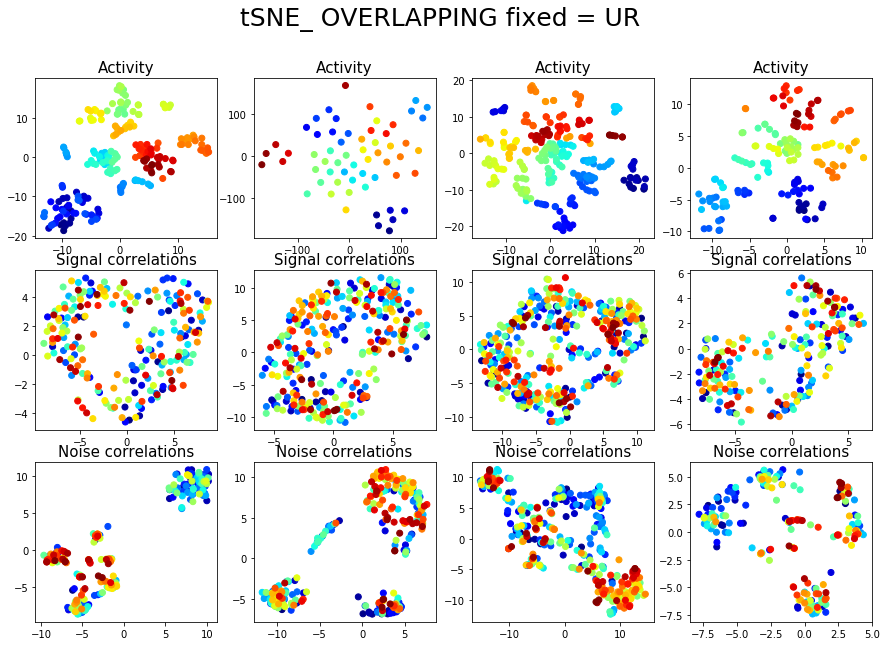

In [11]:
n_components = 2
fig = plt.figure()
gs = plt.GridSpec(3, 4)

for j in range(len(corr_matrix_signal_list)):
    if object_list[j]: 
        embedded_activity = TSNE(n_components=n_components, perplexity=30.0, n_iter=3000,).fit_transform(matrix_list[j].T)
        ax = fig.add_subplot(gs[0, j])
        color = np.linspace(0, 20, embedded_activity.shape[0])
        ax.scatter(embedded_activity [:,0],embedded_activity[:,1], c=color, cmap=cmap)
        ax.set_title('Activity', fontsize = 15)

        embedded_signal = TSNE(n_components=n_components, perplexity=50.0, n_iter=3000,).fit_transform(corr_matrix_signal_list[j].T)
        ax = fig.add_subplot(gs[1, j])
        color = np.linspace(0, 20, corr_matrix_signal_list[j].shape[1])
        ax.scatter(embedded_signal[:,0],embedded_signal[:,1], c=color, cmap=cmap)
        ax.set_title('Signal correlations', fontsize = 15)
        embedded_noise = TSNE(n_components=n_components, perplexity=50.0, n_iter=3000,).fit_transform(corr_matrix_noise_list[j].T)
        ax = fig.add_subplot(gs[2, j])
        ax.scatter(embedded_noise[:,0],embedded_noise[:,1], c=color, cmap=cmap)
        ax.set_title('Noise correlations', fontsize = 15)

fig.set_size_inches(15,10)

fig.suptitle('tSNE_ ' + task + ' fixed = ' + fixed   , fontsize = 25)
figure_name = figure_path + 'tSNE_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

## Sorting neurons by maximum position in time

In [12]:
## sorted by position in time

mean_over_trials_list = []
corr_matrix_signal_list = []
corr_matrix_noise_list = []
matrix_list = []

for i in range(len(object_list)):
    if object_list[i]: 
        mean_over_trials =  np.mean(object_list[i], axis= 0)
        mean_firing_rate = np.mean(mean_over_trials, axis = 1)
        positions = np.flip(np.argsort(mean_firing_rate))
        new_mean_over_trials = mean_over_trials[positions,:]
        non_zero_positions = np.where(np.mean(new_mean_over_trials,axis=1))
        non_zero_mean_over_trials = new_mean_over_trials[non_zero_positions,:]
        non_zero_mean_over_trials = non_zero_mean_over_trials [0,:,:]
        time_sort = np.argsort(np.argmax(non_zero_mean_over_trials,axis=1))
        non_zero_mean_over_trials = non_zero_mean_over_trials[time_sort,:]

        mean_over_trials_list.append(non_zero_mean_over_trials)

        positions1 = positions[np.where(mean_firing_rate[positions])]
        corr_matrix2 = stats.corr_matrix(neural_activity = non_zero_mean_over_trials)
        corr_matrix_signal_list.append(corr_matrix2)

        matrix = np.zeros((positions1.shape[0],period*len(object_list[i])))
        for j in range(len(object_list[i])):
            matrix[:,j*period:(j+1)*period] = object_list[i][j][positions1,:] - mean_over_trials[positions1,:]
        matrix_list.append(matrix)
        corr_matrix = stats.corr_matrix(neural_activity = matrix)
        corr_matrix_noise_list.append(corr_matrix)

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


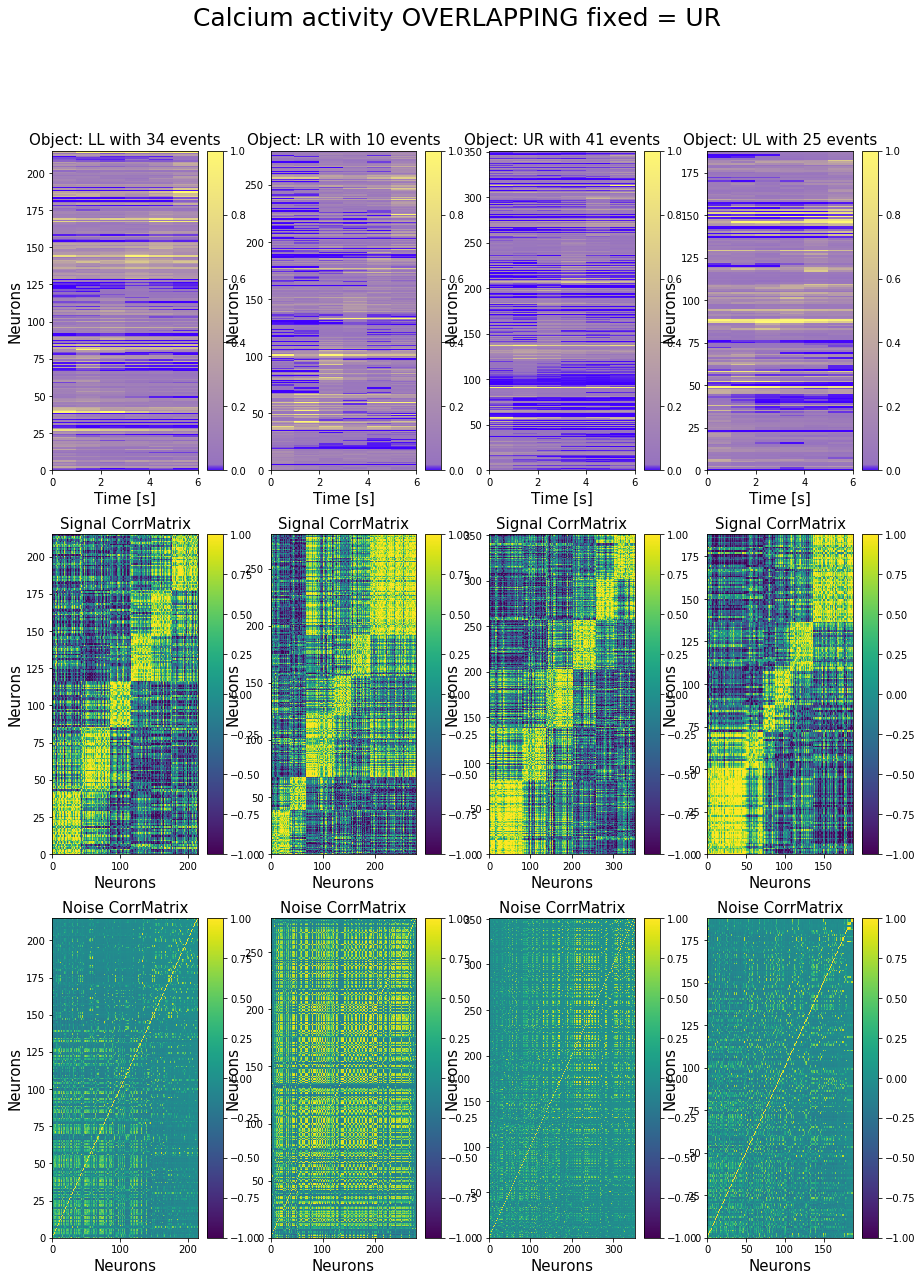

In [13]:
vmin= 0
vmax=1
fig = plt.figure()
gs = plt.GridSpec(3, 4)

i=0
for j in range(4):
    if object_list[j]: 
        ax = fig.add_subplot(gs[i, j])
        ax.set_title('Object: '+ conditions[j] + ' with ' + f'{len(object_list[j])}' + ' events' , fontsize = 15)
        ax.set_ylabel('Neurons', fontsize = 15)
        ax.set_xlabel('Time [s]', fontsize = 15)
        mesh = ax.pcolormesh(mean_over_trials_list[j], cmap = cm)
        mesh.set_clim(vmin,vmax)
        fig.colorbar(mesh,ax=ax)

vmin_corr = -1
vmax_corr = 1
i=1
for j in range(4):
    if object_list[j]: 
        ax3 = fig.add_subplot(gs[i, j])
        ax3.set_ylabel('Neurons', fontsize = 15)
        ax3.set_xlabel('Neurons', fontsize = 15)
        ax3.set_title('Signal CorrMatrix', fontsize = 15)
        mesh3 = ax3.pcolormesh(corr_matrix_signal_list[j], cmap = 'viridis')
        mesh3.set_clim(vmin_corr,vmax_corr)
        fig.colorbar(mesh3,ax=ax3)

i=2
for j in range(4):
    if object_list[j]: 
        ax3 = fig.add_subplot(gs[i, j])
        ax3.set_ylabel('Neurons', fontsize = 15)
        ax3.set_xlabel('Neurons', fontsize = 15)
        ax3.set_title('Noise CorrMatrix', fontsize = 15)
        mesh3 = ax3.pcolormesh(corr_matrix_noise_list[j], cmap = 'viridis')
        mesh3.set_clim(vmin_corr,vmax_corr)
        fig.colorbar(mesh3,ax=ax3)


fig.tight_layout()
fig.set_size_inches(15,20)
fig.suptitle('Calcium activity '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'calcium_activity_and_corr_mouse_time_sorted_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)


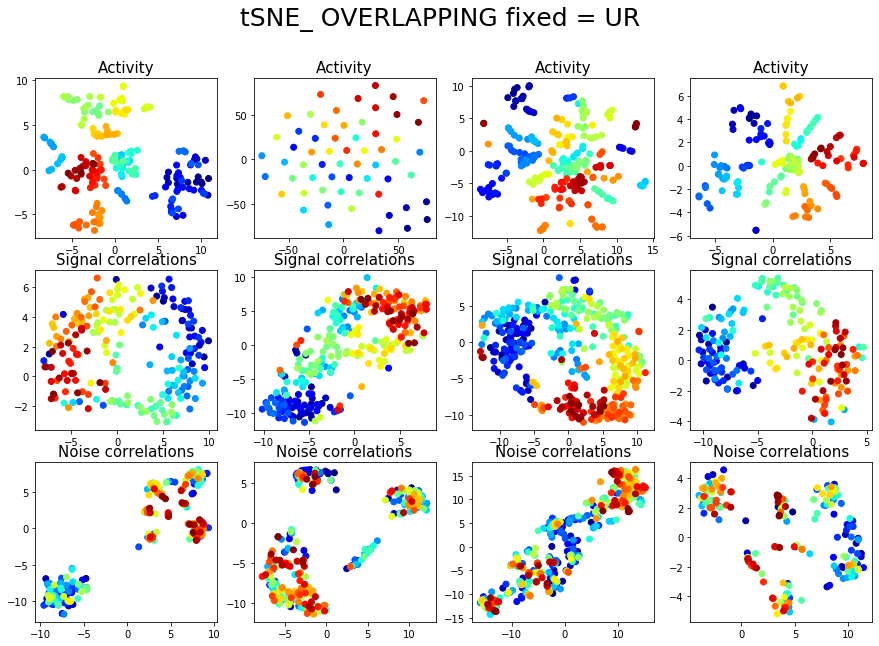

In [14]:
n_components = 2
fig = plt.figure()
gs = plt.GridSpec(3, 4)

for j in range(len(corr_matrix_signal_list)):
    if object_list[j]: 
        embedded_activity = TSNE(n_components=n_components, perplexity=50.0, n_iter=3000,).fit_transform(matrix_list[j].T)
        ax = fig.add_subplot(gs[0, j])
        color = np.linspace(0, 20, embedded_activity.shape[0])
        ax.scatter(embedded_activity [:,0],embedded_activity[:,1], c=color, cmap=cmap)
        ax.set_title('Activity', fontsize = 15)

        embedded_signal = TSNE(n_components=n_components, perplexity=50.0, n_iter=3000,).fit_transform(corr_matrix_signal_list[j].T)
        ax = fig.add_subplot(gs[1, j])
        color = np.linspace(0, 20, corr_matrix_signal_list[j].shape[1])
        ax.scatter(embedded_signal[:,0],embedded_signal[:,1], c=color, cmap=cmap)
        ax.set_title('Signal correlations', fontsize = 15)
        embedded_noise = TSNE(n_components=n_components, perplexity=50.0, n_iter=3000,).fit_transform(corr_matrix_noise_list[j].T)
        ax = fig.add_subplot(gs[2, j])
        ax.scatter(embedded_noise[:,0],embedded_noise[:,1], c=color, cmap=cmap)
        ax.set_title('Noise correlations', fontsize = 15)

fig.set_size_inches(15,10)

fig.suptitle('tSNE_ ' + task + ' fixed = ' + fixed   , fontsize = 25)
figure_name = figure_path + 'tSNE_time_sorted_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)